### Идея ноутбука: руками реализовать основные компоненты 

# 1. Введение

цикл обучения сети выглядит примерно так


```
однослойная нейросеть
model = Sequential()
model.add(Linear(2,2))
model.add(LogSoftMax())

criterion = NLLCriterion()

optimizer = SGD(lr=1e-2, momentum=0.9)

# одна эпоха -- один проход по обучающей выборке
for i in range(n_epoch):
    # одна итерация -- один батч
    for x_batch, y_batch in train_generator(sample, labels, batch_size):
        # Обнуляем градиенты с предыдущей итерации
        model.zero_grad_params()
        # Forward pass
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        # Backward pass
        last_grad_input = criterion.backward(predictions, y_batch)
        model.backward(x_batch, last_grad_input)
        # Обновление весов
        optimizer(
            model.get_params(),
            model.get_grad_params(),
            opt_params,
            opt_state
        )

## Проектирование фреймворка

### 1. Базовые концепции

**Нейросеть** $-$ это последовательность слоев. В реализации ее удобно представлять абстракцией `Sequential`

**Слой** $-$ это некоторая функция, у которой в общем случае есть обучаемые параметры. Есть слои и без обучаемых параметров (например, функции активации, SoftMax, LogSoftMax), однако все эти функции все равно удобно называть слоями нейросети. В реализации один слой удобно представлять абстракцией `Module`

Каждый слой должен уметь делать прямой проход **forward pass**, и обратный проход **backward pass**. В реализации forward pass удобно представлять абстрактным методом `forward()`, backward pass &mdash; абстрактным методом `backward()`


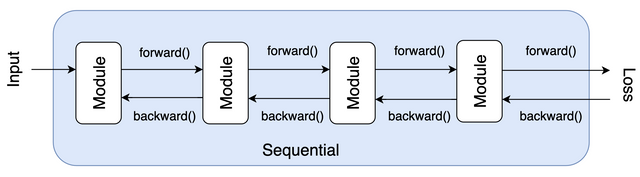

In [ ]:
import numpy as np

**Module** $-$ абстрактный класс, который определяет методы, которые могут быть реализованы у каждого слоя

*   forward pass: просто вычисляет операцию слоя:
    `output = module.forward(input)`

*   backward pass: дифференцирует функцию слоя по входу и по параметрам, возвращает градиент по входу этого слоя:
    `grad_input = module.backward(input, grad_output)`

In [7]:
class Module(object):
    """ Абстрактный класс для слоев нейросети """
    def __init__ (self):
        self.output = None
        self.grad_input = None

    def forward(self, input):
        return self.update_output(input)

    def backward(self, input, grad_output):
        """
        для backpropagation
        """

        self.update_grad_input(input, grad_output)
        self.update_grad_params(input, grad_output)
        return self.grad_input

    def update_output(self, input):
        """
        Вычисляет функцию слоя (линейную, `ReLU`, `SoftMax`) по входу `input`.
            `input (np.array)` -- вход слоя
        returns:
            `self.output (np.array)` -- вычисленная операция слоя, сохраненная в поле класса
        """
        pass

    def update_grad_input(self, input, grad_output):
        """
        ищет градиент функции потерь по входу `input` и возвращает его в виде `self.grad_input`.
        размер (`shape`) поля `self.grad_input` всегда совпадает с размером `input`.
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        returns:
            `self.grad_input (np.array)` -- вычисленный градиент функции  потерь по входу `input`
        """
        pass

    def update_grad_params(self, input, grad_output):
        """
        ищет градиент функции потерь по параметрам (весам) этого слоя.
        ничего не возвращает, только сохраняет значения градиентов в соответствующие поля.
        не нужно реализовывать этот метод, если у слоя нет параметров (у функций активации,
        `SoftMax`, `LogSoftMax`).
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        pass

    def zero_grad_params(self):
        """
        обнуляет градиенты у параметров слоя (если они есть)
        нужен для оптимизатора
        """
        pass

    def get_parameters(self):
        """
        вернет список параметров этого слоя, если они есть. иначе вернет пустой список.
        нужен для оптимизатора.
        """
        return []

    def get_grad_params(self):
        """
        вернет список градиентов функции этого слоя по параметрам этого слоя, если они есть.
        иначе вернет пустой список. нужен для оптимизитора.
        """
        return []


    def __repr__(self):
        """
        напечаиать название слоя КРАСИВО.
        """
        return 'Module'

### Sequential

Многослойная нейронная сеть состоит из последовательности модулей. Реализуем класс **Sequential**. Ниже есть хорошая картинка для понимания

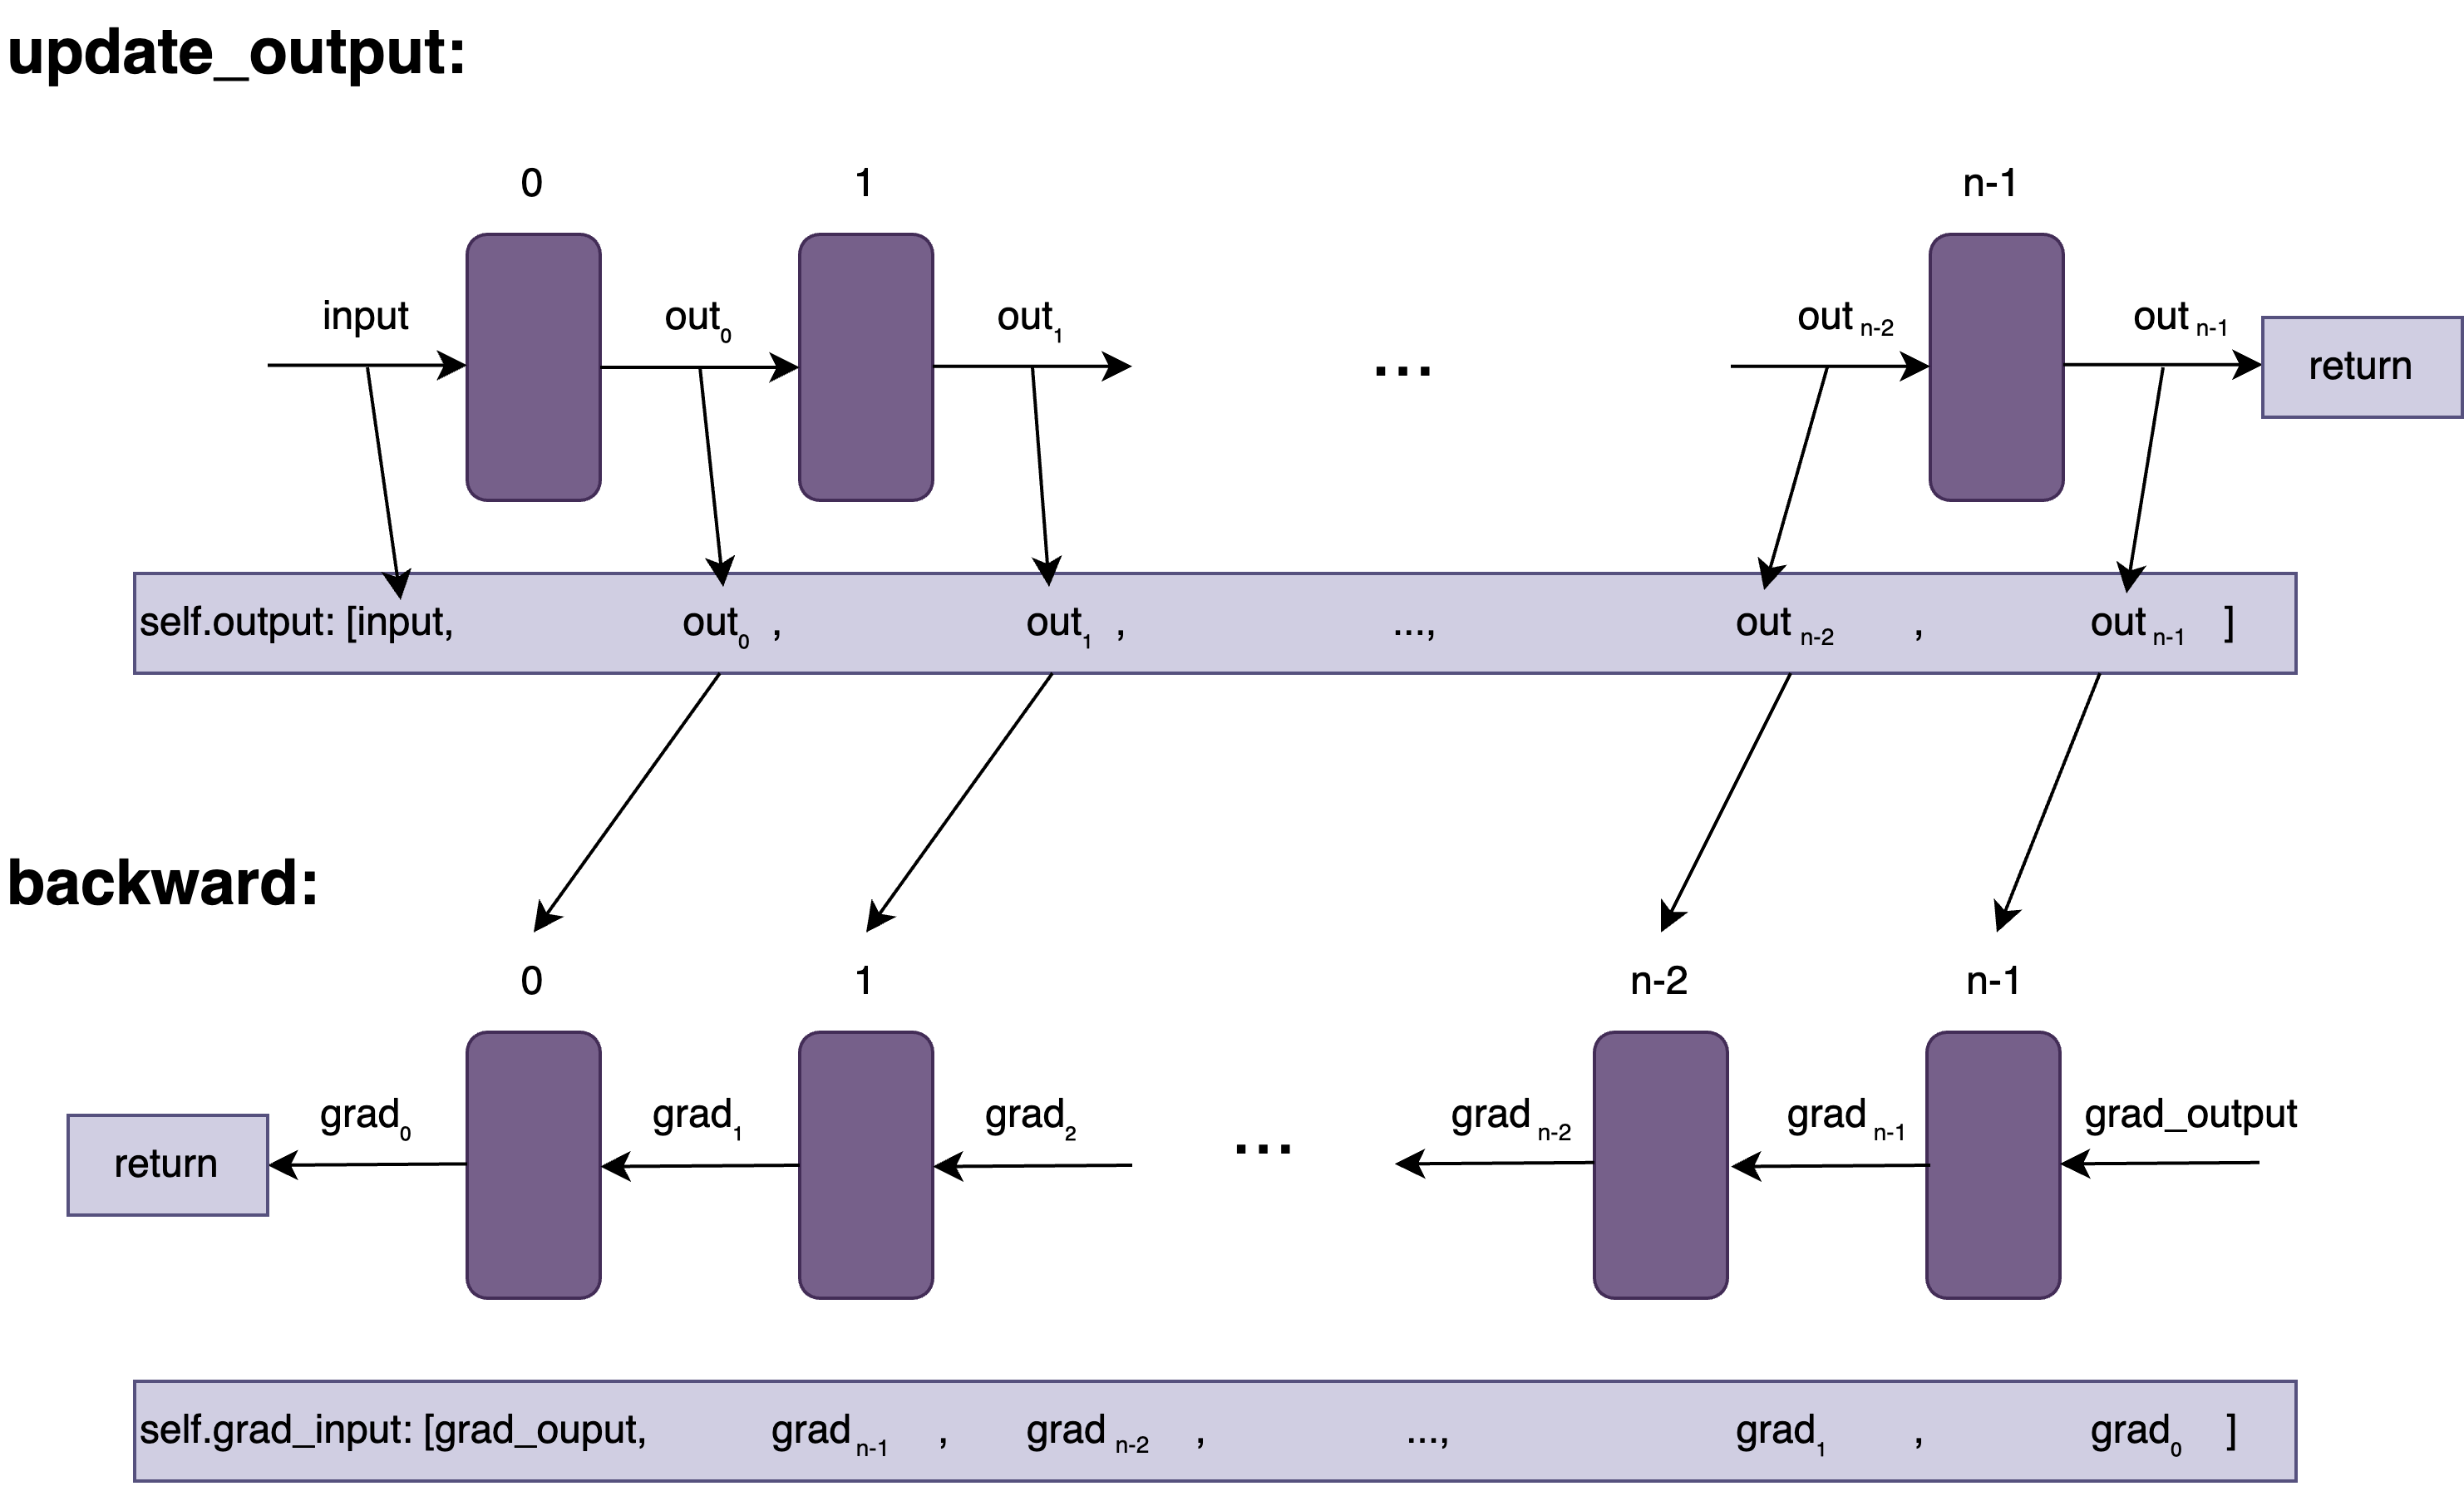

In [8]:
class Sequential(Module):
    """
        послед-ть модулей (слоев)
        послед-но обрабатывает вход `input` от слоя к слою
    """
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        добавляет модуль в контейнер
        """
        self.modules.append(module)

    def update_output(self, input):
        """
        сохраняет выходы каждого модуля в self.output
        возвращает выход последнего модуля
        """
        self.output = [input]
        for i in range(len(self.modules)):
            self.output.append(self.modules[i].forward(self.output[-1]))
        return self.output[-1]

    def backward(self, input, grad_output):
        """
        сохраняет градиенты функции потерь по входу для каждого модуля в self.grad_input
        возвращает первый такой градиент
        """
        self.grad_input = [grad_output]
        for i in range(len(self.modules)-1, -1, -1):
            self.grad_input.append(self.modules[i].backward(self.output[i], self.grad_input[-1]))
        return self.grad_input[-1]


    def zero_grad_params(self):
        """
        обнлуяет градиенты у параметров слоя (если они есть)
        нужно для оптимизатора
        """
        for module in self.modules:
            module.zero_grad_params()

    def get_parameters(self):
        return [x.get_parameters() for x in self.modules]

    def get_grad_params(self):
        return [x.get_grad_params() for x in self.modules]

    def __repr__(self):
        return "".join([str(x) + '\n' for x in self.modules])

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

## Слои

### Linear

Слой делает афинное преобразование

*Forward pass:*

$$
x \in \mathbb{R}^{N \times d}, W \in \mathbb{R}^{d \times K}, b \in \mathbb{R}^{1 \times K}
$$

$$
\text{Linear}(x) = x W + b
$$

$$
\text{Linear}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial Y} \frac{\partial Y}{\partial W} =  x^T \frac{\partial L}{\partial Y};$

$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial Y} \frac{\partial Y}{\partial b} = e_N \frac{\partial L}{\partial Y};$ где $e_N - $ это вектор из единиц $\in \mathbb{R}^{1 \times N}$

$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial Y} \frac{\partial Y}{\partial x} = \frac{\partial L}{\partial Y} W^T;$

In [ ]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def update_output(self, input):
        self.output = input @ self.W + self.b
        return self.output

    def update_grad_input(self, input, grad_output):
        self.grad_input = grad_output @ self.W.T
        return self.grad_input

    def update_grad_params(self, input, grad_output):
        grad_output = np.array(grad_output)
        self.gradW = input.T @ grad_output
        self.gradb = grad_output.sum(axis=0)  # grad_output @ np.ones(self.b.shape[0])[:,None]
        assert self.gradb.shape == self.b.shape

    def zero_grad_params(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def get_parameters(self):
        return [self.W, self.b]

    def get_grad_params(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = f'Linear {s[0]} -> {s[1]}'
        return q

### SoftMax

SoftMax слой осуществляет softmax-преобразование:

$$
\text{SoftMax}(x)_i = \frac{\exp(x_i)} {\sum_j \exp(x_j)}
$$

*Forward pass:*

Обозначим `batch_size` = $N$, `n_in` = $K$.

$$
x \in \mathbb{R}^{N \times K}
$$

Тогда для батча SoftMax записывается так:

$$
\text{SoftMax}(x) = \begin{pmatrix}
\frac{e^{x_{11}}} {\sum_{j=1}^K e^{x_{1j}}} & \frac{e^{x_{12}}}{\sum_{j=1}^K e^{x_{1j}}} & \dots & \frac{e^{x_{1K}}} {\sum_{j=1}^K e^{x_{1j}}} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{e^{x_{N1}}} {\sum_{j=1}^K e^{x_{Nj}}} & \frac{e^{x_{N2}}} {\sum_{j=1}^K e^{x_{Nj}}} & \dots & \frac{e^{x_{NK}}} {\sum_{j=1}^K e^{x_{Nj}}}
\end{pmatrix}
$$

$$
\text{SoftMax}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

SoftMax не имеет параметров, но применяется ко входу поэлементно, поэтому дифференцируя выход этого слоя по входу мы получаем не градиент (=вектор производных), а якобиан (=матрицу производных). Пусть $x$ сейчас $-$ это **один вектор-строка из батча**, имеющая длину $K$.

#### Якобиан SoftMax по входу:



Помним, что:

$$
\text{SoftMax}(x) = \begin{pmatrix}
\dfrac{e^{x_1}}{\sum_{j=1}^K e^{x_{j}}} & \dfrac{e^{x_2}}{\sum_{j=1}^K e^{x_{j}}} & \dots \dfrac{e^{x_K}} {\sum_{j=1}^K e^{x_{j}}}
\end{pmatrix} = \begin{pmatrix}
b_1 & b_2 & \dots & b_K
\end{pmatrix}
$$

$-$ обозначали за $b$ для удобства. Тогда:

$$
\frac{\partial\text{SoftMax}}{\partial x} = \begin{pmatrix}
\frac{\partial b_1}{\partial x_1} & \frac{\partial b_1}{\partial x_2} & \dots & \frac{\partial b_1}{\partial x_K} \\
\frac{\partial b_2}{\partial x_1} & \frac{\partial b_2}{\partial x_2} & \dots & \frac{\partial b_2}{\partial x_K} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{\partial b_K}{\partial x_1} & \frac{\partial b_K}{\partial x_2} & \dots & \frac{\partial b_K}{\partial x_K} \\
\end{pmatrix}
$$

Распишем один элемент этой матрицы и поймем, какой конкретно вид он имеет. Возьмем частную производную $b_i$ по $x_s$:

$$
\frac{\partial{b_i}}{\partial{x_s}} = \frac{1}{\sum_{j=1}^K e^{x_{j}}} \frac{\partial{e^{x_i}}}{\partial{x_s}}
+ \frac{\partial{\frac{1}{\sum_{j=1}^K e^{x_{j}}}}}{\partial{x_s}} e^{x_i} =
\frac{1}{\sum_{j=1}^K e^{x_{j}}} \frac{\partial{e^{x_i}}}{\partial{x_s}} -
\frac{1}{\left( \sum_{j=1}^K e^{x_{j}} \right) ^2} \frac{\partial{\sum_{j=1}^K e^{x_{j}}}}{\partial{x_s}} e^{x_i} =
\frac{1}{\sum_{j=1}^K e^{x_{j}}} \frac{\partial{e^{x_i}}}{\partial{x_s}} -
\frac{e^{x_i}}{\left( \sum_{j=1}^K e^{x_{j}} \right) ^2} \sum_{j=1}^K\frac{\partial{ e^{x_{j}}}}{\partial{x_s}}
=
\frac{1}{\sum_{j=1}^K e^{x_{j}}} \frac{\partial{e^{x_i}}}{\partial{x_s}} -
\frac{e^{x_i + x_s}}{\left( \sum_{j=1}^K e^{x_{j}} \right) ^2}
$$

Далее все зависит от $k$ и $s$. Если $k = s$, то первое слагаемое в (1) не зануляется и мы получаем:

$$
\frac{\partial b_k} {\partial x_k} = \frac{e^{x_k} }{\sum_{j=1}^K e^{x_{j}}} -
    \frac{e^{x_k + x_k}}{\left( \sum_{j=1}^K e^{x_{j}} \right) ^2}  = \frac{e^{x_k} }{\sum_{j=1}^K e^{x_{j}}} \left( 1 - \frac{e^{x_k} }{\sum_{j=1}^K e^{x_{j}}} \right) = a_k(1 - a_k)
$$

**Note.** В данных обозначениях :

$$
a_{k} = \frac{e^{x_k} }{\sum_{j=1}^K e^{x_{j}}}
$$

Если же $i \ne s$, то первое слагаемое в (1) обнулится:

$$
\frac{\partial b_i}{\partial x_s} = - a_{i}a_{s}
$$

Таким образом для **одной строки в батче** получаем:

$$
\frac{\partial\text{SoftMax}}{\partial x} = \begin{pmatrix}
a_1(1 - a_1) & -a_1a_2 & \dots & -a_1a_K \\
-a_2a_1 & a_2(1 - a_2) & \dots & -a_2a_K \\
\vdots  & \vdots  & \ddots & \vdots  \\
-a_Ka_1 & -a_Ka_2 & \dots & a_K(1 - a_K) \\
\end{pmatrix}
$$

Вывод `grad_input`:

$$
\frac{\partial L}{\partial x_s} = \sum_{i=1}^K \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} \frac{\partial b_s}{\partial x_s} + \sum_{i\ne s} \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} =
\frac{\partial L}{\partial b_s} \left(a_s(1-a_s) \right) + \sum_{i\ne s} \frac{\partial L}{\partial b_i} (-a_ia_s) =
a_s\frac{\partial L}{\partial b_s} - a_sa_s \frac{\partial L}{\partial b_s} - \sum_{i\ne s} \frac{\partial L}{\partial b_i}(a_ia_s) =
a_s\frac{\partial L}{\partial b_s} -  \sum_{i=1}^K \frac{\partial L}{\partial b_i}a_ia_s
=
a_s\left(\frac{\partial L}{\partial b_s} -  \sum_{i=1}^K \frac{\partial L}{\partial b_i}a_i \right)
$$

Теперь легко записать формулу для `grad_input` в матричной форме, что и есть выход метода `update_grad_input()`

In [ ]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def update_output(self, input):
        """
            `input (np.array)` -- вход слоя
        """

        # нормализуем для численной устойчивости
        self.output = input - input.max(axis=1, keepdims=True)
        self.output = np.exp(self.output)
        self.output = self.output / (np.sum(self.output, axis=1)).reshape(-1, 1)
        return self.output

    def update_grad_input(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """
        input_clamp = input - input.max(axis=1, keepdims=True)
        output = np.exp(input_clamp)
        output = output / np.sum(output, axis=1).reshape(-1, 1)

        self.grad_input = grad_output * output
        self.grad_input -= output * np.sum(grad_output * output, axis=1).reshape(-1, 1)

        return self.grad_input

    def __repr__(self):
        return 'SoftMax'

### 2.2.3. LogSoftMax &mdash; полностью реализован за вас

LogSoftMax слой есть просто логарифм от softmax-преобразования:

$$
\text{LogSoftMax}(x)_i = \log(\text{SoftMax}(x))_i = x_i - \log {\sum_j \exp x_j}
$$

*Forward pass:*

Обозначим `batch_size` = $N$, `n_in` = $K$.

$$
x \in \mathbb{R}^{N \times K}
$$

Тогда для батча LogSoftMax записывается так:

$$
\text{LogSoftMax}(x) = \begin{pmatrix}
x_{11} - \log {\sum_{j=1}^K e^{x_j}} & x_{12} - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_{1K} - \log {\sum_{j=1}^K e^{x_j}} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{N1} - \log {\sum_{j=1}^K e^{x_j}} & x_{N2} - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_{NK} - \log {\sum_{j=1}^K e^{x_j}} \\
\end{pmatrix}
$$

$$
\text{LogSoftMax}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

LogSoftMax не имеет параметров, но применяется ко входу поэлементно, поэтому дифференцируя выход этого слоя по входу мы получаем не градиент (=вектор производных), а якобиан (=матрицу производных). Пусть $x$ сейчас $-$ это **один вектор-строка из батча**, имеющая длину $K$.

#### Якобиан LogSoftMax по входу:

Помним, что:

$$
\text{LogSoftMax}(x) = \begin{pmatrix}
x_1 - \log {\sum_{j=1}^K e^{x_j}} & x_2 - \log {\sum_{j=1}^K e^{x_j}} & \dots & x_K - \log {\sum_{j=1}^K e^{x_j}}
\end{pmatrix} = \begin{pmatrix}
b_1 & b_2 & \dots & b_K
\end{pmatrix}
$$

$-$ обозначали за $b$ для удобства. Тогда:

$$
\frac{\partial\text{LogSoftMax}}{\partial x} = \begin{pmatrix}
\frac{\partial b_1}{\partial x_1} & \frac{\partial b_1}{\partial x_2} & \dots & \frac{\partial b_1}{\partial x_K} \\
\frac{\partial b_2}{\partial x_1} & \frac{\partial b_2}{\partial x_2} & \dots & \frac{\partial b_2}{\partial x_K} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{\partial b_K}{\partial x_1} & \frac{\partial b_K}{\partial x_2} & \dots & \frac{\partial b_K}{\partial x_K} \\
\end{pmatrix}
$$

Распишем один элемент этой матрицы и поймем, какой конкретно вид он имеет. Возьмем частную производную $b_k$ по $x_s$:

$$
\frac{\partial b_k}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_s} \tag{1}
$$

Далее все зависит от $k$ и $s$. Если $k = s$, то первое слагаемое в (1) не зануляется и мы получаем:

$$
\frac{\partial b_k}{\partial x_k} = \frac{\partial x_k}{\partial x_k} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = 1 - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_k} = 1 - a_k
$$

**Где $a_k$ $-$ это $k$-ая компонента SoftMax-слоя от этого входа**. Если же $k \ne s$, то первое слагаемое в (1) обнулится:

$$
\frac{\partial b_k}{\partial x_s} = \frac{\partial x_k}{\partial x_s} - \frac{\partial \log {\sum_{j=1}^K e^{x_j}}}{\partial x_s} = - \frac{1}{\sum_{j=1}^K e^{x_j}} e^{x_s} = a_s
$$

Таким образом для **одной строки в батче** получаем:

$$
\frac{\partial\text{LogSoftMax}}{\partial x} = \begin{pmatrix}
(1 - a_1) & -a_2 & \dots & -a_K \\
-a_1 & (1 - a_2) & \dots & -a_K \\
\vdots  & \vdots  & \ddots & \vdots  \\
-a_1 & -a_2 & \dots & (1 - a_K) \\
\end{pmatrix}
$$

#### Вывод `grad_input`:

$$
\frac{\partial L}{\partial x_s} = \sum_{i=1}^K \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} \frac{\partial b_s}{\partial x_s} + \sum_{i\ne s} \frac{\partial L}{\partial b_i}\frac{\partial b_i}{\partial x_s} = \frac{\partial L}{\partial b_s} (1 - a_s) + \sum_{i\ne s} \frac{\partial L}{\partial b_i} (-a_s) =
\frac{\partial L}{\partial b_s} - a_s \frac{\partial L}{\partial b_s} - a_s \sum_{i\ne s} \frac{\partial L}{\partial b_i} = \frac{\partial L}{\partial b_s} - a_s \sum_{i=1}^K \frac{\partial L}{\partial b_i}
$$

Теперь легко записать формулу для `grad_input` в матричной форме, что и есть выход метода `update_grad_input()`.

В коде используем свойство: $\text{LogSoftMax}(x) = \text{LogSoftMax}(x - \text{const})$. Это позволяет избежать переполнения при вычислении экспоненты.

In [ ]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def update_output(self, input):
        # нормализуем для численной устойчивости
        self.output = input - input.max(axis=1, keepdims=True)
        self.output = self.output - np.log(np.sum(np.exp(self.output), axis=1)).reshape(-1, 1)
        return self.output

    def update_grad_input(self, input, grad_output):
        input_clamp = input - input.max(axis=1, keepdims=True)
        output = np.exp(input_clamp)
        output = output / np.sum(output, axis=1).reshape(-1, 1)

        self.grad_input = grad_output
        self.grad_input -= output * np.sum(grad_output, axis=1).reshape(-1, 1)

        return self.grad_input

    def __repr__(self):
        return 'LogSoftMax'

## Функции активации

### 2.3.1. ReLU

**[Rectified Linear Unit](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf)** (**ReLU**)

*Forward pass:*

Применяется поэлементно.

$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{ReLU}(x) = \max(0, x) = \begin{cases}
  0, & x \le 0 \\    
  x & x \gt 0    
\end{cases}
$$

$$
\text{ReLU}(x) \in \mathbb{R}^{N \times K}
$$

*Backward pass:*

$$ \frac{\partial{L}}{\partial{x_j}} = \sum^{n}_{i=1} \frac{\partial{L}}{\partial{ReLU(x_i)}}\frac{\partial{ReLU(x_i)}}{\partial{x_i}}$$

$$
\frac{\partial{ReLU(x)}}{\partial{x}} = \begin{cases}
  0, & x \le 0 \\    
  1 & x \gt 0    
\end{cases}
$$

In [ ]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def update_output(self, input):
        """
            `input (np.array)` -- вход слоя
        """

        # нормализуем для численной устойчивости
        self.output = np.maximum(input, 0)
        return self.output

    def update_grad_input(self, input, grad_output):
        """
            `input (np.array)` -- вход слоя
            `grad_output (np.array)` -- градиент по выходу этого слоя, пришедший от следующего слоя
        """

        self.grad_input = np.multiply(grad_output, input > 0)
        return self.grad_input

    def __repr__(self):
        return 'ReLU'

### Leaky ReLU

**[Leaky Rectified Linear Unit](https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)** (**LeakyReLU**) 

*Forward pass:*

Применяется поэлементно.


$$
x \in \mathbb{R}^{N \times K}
$$

$$
\text{LeakyReLU}(x) = \begin{cases}
  \gamma x, & x \le 0 \\    
  x & x \gt 0    
\end{cases}
$$

$$
\text{LeakyReLU}(x) \in \mathbb{R}^{N \times K}
$$



Выводится аналогично прошлому пункту
$$
\frac{\partial{ReLU(x)}}{\partial{x}} =  \begin{cases}
  \gamma, & x \le 0 \\    
  1 & x \gt 0    
\end{cases}
$$

In [ ]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def update_output(self, input):
        self.output = np.maximum(input, self.slope * input)
        return self.output

    def update_grad_input(self, input, grad_output):
        self.grad_input = np.where(input > 0, grad_output, grad_output * self.slope)
        return self.grad_input

    def __repr__(self):
        return 'LeakyReLU'

## Функции потерь (loss, criterion, objective)

### Negative LogLikelihood criterion

**[NLLCriterion](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)**

Истинные метки `y` на вход ожидаются уже **после One-Hot кодирования**.

*Forward pass:*

$$
\widehat{y} \in \mathbb{R}^{N \times K}
$$

$$
y \in \mathbb{R}^{N \times K}
$$

$$
\text{NLLCriterion}(\widehat{y}, y) = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \widehat{y}_{ij}
$$

$$
\text{NLLCriterion}(\widehat{y}, y) \in \mathbb{R}
$$

*Backward pass:*
$NLL(\hat{y}, y) = -\frac{1}{N} y_{ij} \hat{y}_{ij}\\
\frac{\partial NLL}{\partial \hat{y}_{ij}} = - \frac{1}{N} y_{ij}\\
\frac{\partial NLL}{\partial \hat{y}} = \big(\frac{\partial NLL}{\partial \hat{y}_{ij}}\big)_{i = 1, j = 1}^{N, K}$

In [ ]:
class NLLCriterion(object):
    def __init__ (self):
        self.output = None
        self.grad_input = None

    def forward(self, input, target):
        return self.update_output(input, target)

    def backward(self, input, target):
        return self.update_grad_input(input, target)

    def update_output(self, input, target):
        self.output = -np.sum(np.multiply(target, input)) / input.shape[0]
        return self.output

    def update_grad_input(self, input, target):
        self.grad_input = -target / input.shape[0]
        return self.grad_input

    def __repr__(self):
        return 'NLLCriterion'

## Оптимизаторы

### SGD

In [9]:
def SGD(variables, gradients, config):
    for current_layer_vars, current_layer_grads in zip(variables, gradients):
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            current_var -= config['learning_rate'] * current_grad